In [ ]:
import matplotlib
matplotlib.__version__

'3.6.1'

In [294]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn import metrics

def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(true, pred):

    mse1 = mse(true, pred)

    rmse1 = rmse(true, pred)

    mae1 = mae(true, pred)

    medae1 = medae(true, pred)

    R21 = R2(true, pred)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}".format(mse1, rmse1, R21, mae1, medae1))
    print('-'*30)

In [295]:
import warnings
warnings.filterwarnings("ignore")

In [296]:
genre_mapping = {'0ef0aa70-f86c-4141-8054-8b39af97867d': 'Biography',
                '287a1485-7a88-4c2f-bc94-ca418b6c47a1': 'Cartoons',
                '66fad8c3-d84f-458d-a8bf-5b4f154969e0': 'Show',
                '7b7c97f6-1adb-4b43-bfe8-9455812fac0b': 'Theater',
                '9fa28b61-a257-4a3e-945b-a9ef76a146d6': 'Fantasy',
                'b0836a1d-635f-4d89-bcc5-25d10ba56642': 'Anime',
                'd7214feb-8c11-4aea-aabb-ac98a8d56fd5': 'History',
                'dc65dbc8-34ba-4df1-b32c-4f895e10bff8': 'Shorts',
                'eb001d27-5be3-4d42-9d88-90d593f2627d': 'War_movies',
                '364fdc2e-bdfe-40be-b2c5-d30f43ec432e': 'Crime',
                '1f22ccf1-288a-4e6e-b39a-7502799e7125': 'Лекции',
                '6d640e04-be3a-4c8c-852e-4e9b12449d5d': 'Концерты',
                '7b7c97f6-1adb-4b43-bfe8-9455812fac0b': 'Театр',
                '2f7908cc-e2fd-43cf-b626-ec1aef436160': 'Курсы'}

In [297]:
with open('/home/jovyan/work/items_df.pkl', 'rb') as f:
    df = pickle.load(f)

In [298]:
df = df[['genre', 'director', 'actor', 'unified_id', 'release_year']]

In [299]:
df.isnull().sum()

genre           8053
director        8063
actor           8054
unified_id         0
release_year    7938
dtype: int64

In [301]:
df.dropna(inplace=True)
df.index = df['unified_id']

# Preprocessing

1. Multiple value categorical features: cat2vec
    
2. Just categorical 
    * type
    * release year (skipped): periods: 1918-1969, 1970-1979, 1980-1989, ... с 2000 по годам, filter by year
3. Numeric and categorical ordered
    * age_access
    * avg_rating
    * duration
4. textual (skipped)
    * name: catboost.text / ruBERT
5. target:
    * \* 100, log

In [331]:
from random  import shuffle
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from random import choices

mltpl_cat_features = ['actor', 'country', 'genre', 'director']
cat_features = ['availability']
cat_features_raw = ['type', 'subscription_only']
num_features = ['age_access_type', 'average_rating', 'duration', 'release_year']
skewed_num_features = ['duration']
text_features = ['name']
mltpl_cat_n_top = {'actor': 5, 'country': 1, 'genre': 3, 'director': 1}


class Cat2Vec:
    def __init__(self, n_cat2vec_feature,
                    n_cat2vec_window):
        self.n_cat2vec_feature = n_cat2vec_feature
        self.n_cat2vec_window = n_cat2vec_window
    
    def __create_tokens(self, col_name, values):
        return [f'{col_name} {value}' for value in values]
    
    def __gen_cat2vec_sentences(self, data):
        items = []

        for i, row in data.iterrows():
            item_values = []
            for col, values in zip(row.index, row.values):
                item_values.extend(self.__create_tokens(col, values))
            # shuffle(item_values)
            items.append(item_values)
        return items
    
    def fit(self, cat_features):
        X_w2v = self.__gen_cat2vec_sentences(cat_features)
        self.model = Word2Vec(X_w2v, vector_size=self.n_cat2vec_feature, 
                         window=self.n_cat2vec_window, epochs=100, min_count=1)
        
    def transform(self, cat_features):
        encoded_features = pd.DataFrame()
        for col in cat_features.columns:
            tokens = [self.__create_tokens(col, row) for row in cat_features[col]]
            col_embeds = []
            for row in tokens:
                avg_embeds = np.mean([self.model.wv[token] for token in row if token in self.model.wv.key_to_index], 
                                          axis=0)
                if isinstance(avg_embeds, np.float64):
                    avg_embeds = [np.nan] * self.n_cat2vec_feature
                    
                col_embeds.append(avg_embeds)
            col_embeds = pd.DataFrame(col_embeds, columns=[f'{col}_{i}' for i in range(self.n_cat2vec_feature)])
            encoded_features = pd.concat([encoded_features, col_embeds], axis=1)

        encoded_features.index = cat_features.index
        return encoded_features

In [311]:
# cat2vec.model.wv.most_similar("genre Family")
# cat2vec.model.wv['genre Family']
# cat2vec.model.wv.key_to_index

cat_cols = ['actor', 'genre', 'director']
n_cat2vec_feature  = len(cat_cols) * 3 # define the cat2vecs dimentions
n_cat2vec_window   = len(cat_cols) * 5

cat2vec = Cat2Vec(n_cat2vec_feature, n_cat2vec_window)
cat2vec.fit(df[df['release_year'] < 2022][cat_cols])
features = cat2vec.transform(df[cat_cols])

In [312]:
features.isnull().sum()

actor_0       56
actor_1       56
actor_2       56
actor_3       56
actor_4       56
actor_5       56
actor_6       56
actor_7       56
actor_8       56
genre_0        0
genre_1        0
genre_2        0
genre_3        0
genre_4        0
genre_5        0
genre_6        0
genre_7        0
genre_8        0
director_0    96
director_1    96
director_2    96
director_3    96
director_4    96
director_5    96
director_6    96
director_7    96
director_8    96
dtype: int64

In [278]:
cat2vec.model.wv.most_similar("genre ForKids", topn=30)

[('actor 118e31dd-a343-45ac-a9bd-621bb7a80f3c', 0.9564614295959473),
 ('actor 435fdc39-e214-4c68-9e09-146011828346', 0.9416858553886414),
 ('actor 8cc14afd-7493-45c6-9808-c7418f7f2e69', 0.9403588771820068),
 ('actor f631423d-c950-44dc-8763-06be69a2b1b7', 0.9389175176620483),
 ('director 56113a27-6800-4563-9348-045767c8a068', 0.9309340119361877),
 ('actor ab40b219-c7d7-400a-8d59-9ef14d9329a5', 0.9294782876968384),
 ('director 88efc11a-6e29-4ae8-8b5c-b2c37572ac38', 0.9275351762771606),
 ('actor 2c0daa50-0a79-4d90-8cf3-a332d44d7eca', 0.9269772171974182),
 ('actor b70c4df9-8e14-4562-920d-61e01d0ff219', 0.9211354851722717),
 ('actor c63ff784-63dc-4ea4-b90b-6bf1bf99e1b0', 0.9181200861930847),
 ('actor e1a83edb-6da0-443a-ac54-be9dda4b2a9d', 0.9146196246147156),
 ('actor 977ca293-f56c-412c-a02d-723f5e43e301', 0.9130696058273315),
 ('actor ec11eb1d-1121-43eb-a5cc-bfdd052a6230', 0.9104337692260742),
 ('actor 42f9c866-5bdc-49d0-86f3-65cf1f56184a', 0.9093641638755798),
 ('director 348f20f4-abc8-4d

In [320]:
features['unified_id'] = features.index
features.index = range(len(features))

# merge

In [332]:
mltpl_cat_features = ['country']
cat_features = ['type']
skewed_num_features = ['duration']
mltpl_cat_n_top = {'actor': 5, 'country': 1, 'genre': 3, 'director': 1}

class Preprocesser:
    def __init__(self, 
                mulpiple_cat_features: list,
                skewed_num_features: list,
                text_features: list,
                cat_features: list,
                mltpl_cat_n_top: dict):
        self.mulpiple_cat_features = mulpiple_cat_features
        self.skewed_num_features = skewed_num_features
        self.text_features = text_features
        self.mltpl_cat_n_top = mltpl_cat_n_top
        self.cat_features = cat_features
       # self.release_year_feature = release_year_feature
        
    def __get_top_n_mltpl_cat_features(self, df_pr, col):
        all_cats = []
        for element_values in df_pr[col]:
            all_cats.extend(element_values)
        return Counter(all_cats).most_common(self.mltpl_cat_n_top[col])
            
    def __preprocess_mulpiple_cat_features(self, df_pr):
        for col in self.mulpiple_cat_features:
            feature_number = self.mltpl_cat_n_top[col]
            df_pr[[f'{col}_{i}' for i in range(feature_number)]] = pd.DataFrame(np.full((len(df), feature_number), np.nan))
            for i in df_pr.index:
                names = df_pr.loc[i, col]
                for k, name in enumerate(names[:int(feature_number)]):
                    df_pr.loc[i, f'{col}_{k}'] = name
            df_pr.drop(col, axis=1, inplace=True)

        return df_pr
    
    def __preprocess_skewed_num_features(self, df_pr):
        for col in self.skewed_num_features:
            df_pr[col] = df_pr[col].apply(lambda x: np.log1p(x))
        return df_pr
    
    def __preprocess_text_features(self, df_pr):
        for col in self.text_features:
            df_pr[[f'{col}_{i}' for i in range(768)]] = self.embed_model.encode(df_pr[col].values)
            df_pr.drop(col, axis=1, inplace=True)
        return df_pr
    
    def __get_unique_values(self, feature):
        unique_values = []
        for element in feature.dropna():
            unique_values.extend(element)
        return set(unique_values)
    
    def __preprocess_cat_features(self, df_pr):
        for col in self.cat_features:
            unique_values = self.__get_unique_values(df_pr[col])
            cats_df = pd.DataFrame(np.full((len(df_pr), len(unique_values)),
                                            0),
                                   columns=list(unique_values))
            
            for i, element in enumerate(df_pr[col]):
                if isinstance(element, float):
                    cats_df.loc[i, :] = 'Na'
                    continue
                for value in element:
                    cats_df.loc[i, value] = '1'
            df_pr.drop(col, axis=1, inplace=True)
        df_pr[cats_df.columns] = cats_df
        return df_pr  
            
    def preprocess(self,
                   df: pd.DataFrame):
        df_pr = df.copy()
        df_pr = self.__preprocess_mulpiple_cat_features(df_pr)
        df_pr = self.__preprocess_skewed_num_features(df_pr)
        # df_pr = self.__preprocess_cat_features(df_pr)
        
        return df_pr
        
class TargetTransformer:
    def __init__(self, denominator=1):
        self.scale = denominator
        
    def inverse_transform(self, feature):
        return feature.apply(lambda x: np.expm1(x))
    
    def transform(self, feature):
        return feature.apply(lambda x: np.log1p(x))

In [351]:
with open('/home/jovyan/work/cold_start_models/dataset_0.pkl', 'rb') as f:
    ds_0 = pickle.load(f)

In [356]:
ds_0.columns

Index(['age_access_type', 'average_rating', 'duration', 'type', 'name',
       'release_year', 'target', 'subscription_only', 'uid', 'actor_0',
       'actor_1', 'actor_2', 'actor_3', 'actor_4', 'country_0', 'genre_0',
       'genre_1', 'genre_2', 'director_0', 'RENT', 'AVOD', 'DTO',
       'SUBSCRIPTION', 'unified_id'],
      dtype='object')

In [328]:
ds_0.rename({'uid': 'unified_id'}, inplace=True)

In [362]:
df_merged = ds_0.merge(features, on='unified_id',
          how='left')[['duration', 'type','release_year', 'target', 'country_0',
                      'unified_id', 'actor_0_y', 'actor_1_y',
                       'actor_2_y', 'actor_3_y', 'actor_4_y', 'actor_5', 'actor_6', 'actor_7',
                       'actor_8', 'genre_0_y', 'genre_1_y', 'genre_2_y', 'genre_3', 'genre_4',
                       'genre_5', 'genre_6', 'genre_7', 'genre_8', 'director_0_y',
                       'director_1', 'director_2', 'director_3', 'director_4', 'director_5',
                       'director_6', 'director_7', 'director_8']]

In [363]:
df_merged.isnull().sum()

duration          0
type              0
release_year      0
target            0
country_0         0
unified_id        2
actor_0_y       116
actor_1_y       116
actor_2_y       116
actor_3_y       116
actor_4_y       116
actor_5         116
actor_6         116
actor_7         116
actor_8         116
genre_0_y       111
genre_1_y       111
genre_2_y       111
genre_3         111
genre_4         111
genre_5         111
genre_6         111
genre_7         111
genre_8         111
director_0_y    143
director_1      143
director_2      143
director_3      143
director_4      143
director_5      143
director_6      143
director_7      143
director_8      143
dtype: int64

In [251]:
# with open('cat2vec_full_catalogue.pkl', 'wb') as f:
#     pickle.dump(cat2vec, f)

In [364]:
# with open('item_coldstart_dataset_preprocessed.pkl', 'wb') as f:
#     pickle.dump(df_pr, f)

# with open('item_coldstart_dataset_preprocessed.pkl', 'rb') as f:
#     df_pr = pickle.load(f)

# with open('item_coldstart_dataset_with_names.pkl', 'wb') as f:
    # pickle.dump(df_pr, f)

# with open('item_coldstart_dataset_with_names.pkl', 'rb') as f:
#     df_pr = pickle.load(f)

with open('item_coldstart_dataset_cat2vec_full.pkl', 'wb') as f:
    pickle.dump(df_merged, f)

# with open('item_coldstart_dataset_cat2vec.pkl', 'rb') as f:
#     df_pr = pickle.load(f)

# Modeling

In [365]:
# with open('item_coldstart_dataset_preprocessed.pkl', 'rb') as f:
#     df_pr = pickle.load(f)

# with open('item_coldstart_dataset_with_names.pkl', 'rb') as f:
#     df_pr = pickle.load(f)

# with open('item_coldstart_dataset_cat2vec.pkl', 'rb') as f:
#     df_pr = pickle.load(f)

with open('item_coldstart_dataset_cat2vec_full.pkl', 'rb') as f:
    df_pr = pickle.load(f)

In [366]:
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error as mae, r2_score as r2
from scipy.stats import uniform, randint

In [367]:
def get_metrics(y_test, y_pred, X):
    y_test = target_transformer.inverse_transform(y_test)
    y_pred = target_transformer.inverse_transform(pd.Series(y_pred))

    print('MAE', mae(y_test, y_pred))
    print('R2', r2(y_test, y_pred))
    print('Adj R2', 1 - (1-r2(y_test, y_pred)) * (len(y)-1)/(len(y)-X.shape[1]-1))
    

def get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png'):
    imp = cat_model.get_feature_importance(data=train_dataset)
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    axes.barh(width=imp, y=cat_model.feature_names_)
    axes.set_title(title)
    if save_fig:
        plt.savefig(file_name)
    plt.show()
    

def draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution'):
    plt.figure(figsize=(12, 5))
    sns.distplot(y_test)
    sns.distplot(y_pred)
    plt.legend(['test', 'pred'])
    if save_fig:
        plt.savefig(file_name)
    plt.show()

    
def draw_residuals(y_test, y_pred, save_fig=False,
                   file_name='cat_residuals.png'):
    y_test = target_transformer.inverse_transform(y_test)
    y_pred = target_transformer.inverse_transform(pd.Series(y_pred))
    sns.residplot(x=y_test, y=y_pred)
    if save_fig:
        plt.savefig(file_name)
    plt.show()

In [368]:
df_pr.columns

Index(['duration', 'type', 'release_year', 'target', 'country_0', 'unified_id',
       'actor_0_y', 'actor_1_y', 'actor_2_y', 'actor_3_y', 'actor_4_y',
       'actor_5', 'actor_6', 'actor_7', 'actor_8', 'genre_0_y', 'genre_1_y',
       'genre_2_y', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7',
       'genre_8', 'director_0_y', 'director_1', 'director_2', 'director_3',
       'director_4', 'director_5', 'director_6', 'director_7', 'director_8'],
      dtype='object')

In [382]:
cat_features = ['type', 'country_0']
num_features = ['duration','country_0', 'unified_id',
               'actor_0_y', 'actor_1_y', 'actor_2_y', 'actor_3_y', 'actor_4_y',
               'actor_5', 'actor_6', 'actor_7', 'actor_8', 'genre_0_y', 'genre_1_y',
               'genre_2_y', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7',
               'genre_8', 'director_0_y', 'director_1', 'director_2', 'director_3',
               'director_4', 'director_5', 'director_6', 'director_7', 'director_8']

In [383]:
df_pr[cat_features]

type    country_0
0      MOVIE          usa
1      MOVIE          usa
2      MOVIE          usa
3      MOVIE          usa
4      MOVIE       canada
...      ...          ...
9478  SERIAL  south-korea
9479  SERIAL          usa
9480  SERIAL  south-korea
9481  SERIAL       france
9482  SERIAL       russia

[9483 rows x 2 columns]

In [384]:
MULTIPLIER = 100
df_pr['release_year'] = df_pr['release_year'].astype(int)
df_short = df_pr[df_pr['release_year'] >= 2020]
X, y = df_short.drop(['target', 'unified_id'], axis=1), df_short['target']  * MULTIPLIER
y = target_transformer.transform(y)

In [385]:
X_train, X_test, y_train, y_test = X[X['release_year'] < 2022], X[X['release_year'] == 2022], \
                                    y[X['release_year'] < 2022], y[X['release_year'] == 2022]
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, shuffle=True)
train_dataset = cat.Pool(X_train, y_train,
                         cat_features=cat_features,   
                        )
test_dataset = cat.Pool(X_test, y_test,
                         cat_features=cat_features,
                       )
val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features,
                      )

In [388]:
X_train.shape

(1355, 31)

## Training

In [387]:
cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features,
    'iterations': 10000, 
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
    eval_set=val_dataset,
    early_stopping_rounds=100,
    verbose=100,
    plot=False
)

Learning rate set to 0.01311
0:	learn: 0.1079694	test: 0.1365716	best: 0.1365716 (0)	total: 1.93ms	remaining: 19.3s
100:	learn: 0.0976500	test: 0.1332740	best: 0.1309509 (40)	total: 173ms	remaining: 16.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1309509391
bestIteration = 40

Shrink model to first 41 iterations.


In [76]:
cat_model.save_model('views_3_cat')

In [389]:
y_pred = cat_model.predict(X_test)

In [390]:
get_metrics(y_test, y_pred, X)

MAE 0.3751353707277355
R2 -0.3086223945320845
Adj R2 -0.3369713073416545


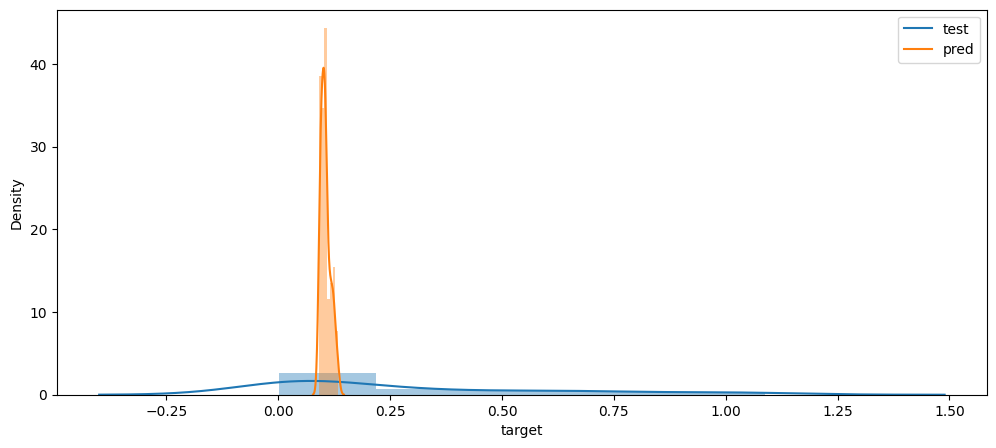

In [391]:
draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution')

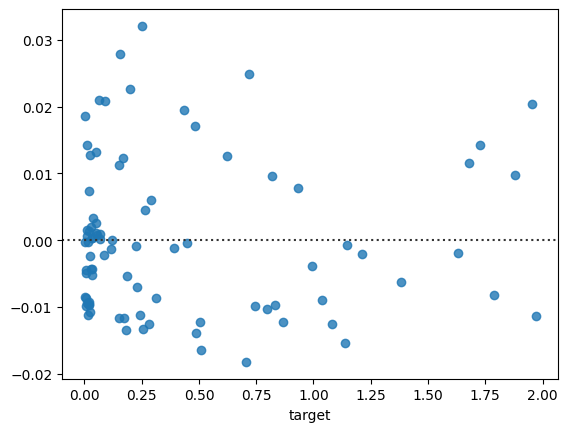

In [392]:
draw_residuals(y_test, y_pred, save_fig=False)

In [393]:
len(y_pred[y_pred <= 0])

0

## Tuning

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, shuffle=True)
train_dataset = cat.Pool(X_train, y_train,
                         cat_features=cat_features,   
                        ) 
test_dataset = cat.Pool(X_test, y_test,
                         cat_features=cat_features,
                       )
val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features,
                      )

In [80]:
cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 100,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

In [ ]:
parameters_distr = {'depth': randint(5, 10),
                    'learning_rate': uniform(0.01, 0.1),
                    'iterations': [1000, 5000, 10000, 15000],
                    'l2_leaf_reg':  uniform(0.01, 0.5)
                     }

cat_model = cat.CatBoostRegressor(**cat_params)
grid = RandomizedSearchCV(estimator=cat_model, param_distributions=parameters_distr, 
                          cv=5, n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)

cat_model = grid.best_estimator_
cat_model.save_model('views_3_finetuned_cat')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, emb

0:	learn: 0.0409679	total: 157ms	remaining: 2m 36s
1:	learn: 0.0402721	total: 187ms	remaining: 1m 33s
2:	learn: 0.0397917	total: 268ms	remaining: 1m 28s
3:	learn: 0.0392163	total: 354ms	remaining: 1m 28s
4:	learn: 0.0386634	total: 487ms	remaining: 1m 36s
5:	learn: 0.0382220	total: 550ms	remaining: 1m 31s
6:	learn: 0.0377707	total: 592ms	remaining: 1m 23s
7:	learn: 0.0374124	total: 674ms	remaining: 1m 23s
8:	learn: 0.0370133	total: 807ms	remaining: 1m 28s
9:	learn: 0.0367166	total: 993ms	remaining: 1m 38s
10:	learn: 0.0364223	total: 1.05s	remaining: 1m 34s
11:	learn: 0.0361288	total: 1.2s	remaining: 1m 38s
12:	learn: 0.0358993	total: 1.37s	remaining: 1m 44s
13:	learn: 0.0356448	total: 1.5s	remaining: 1m 45s
14:	learn: 0.0354023	total: 1.61s	remaining: 1m 45s
15:	learn: 0.0351398	total: 1.81s	remaining: 1m 51s
16:	learn: 0.0349367	total: 1.94s	remaining: 1m 52s
17:	learn: 0.0347334	total: 2.02s	remaining: 1m 50s
18:	learn: 0.0345633	total: 2.11s	remaining: 1m 48s
19:	learn: 0.0343588	tot

In [56]:
# best_cat = cat.CatBoostRegressor(**cat_params)      # parameters not required.
# best_cat.load_model('views_3_finetuned_cat')

In [82]:
y_pred = cat_model.predict(X_test)

MAE 0.03367143740403902
R2 0.19489317778678694
Adj R2 0.1921199528308316


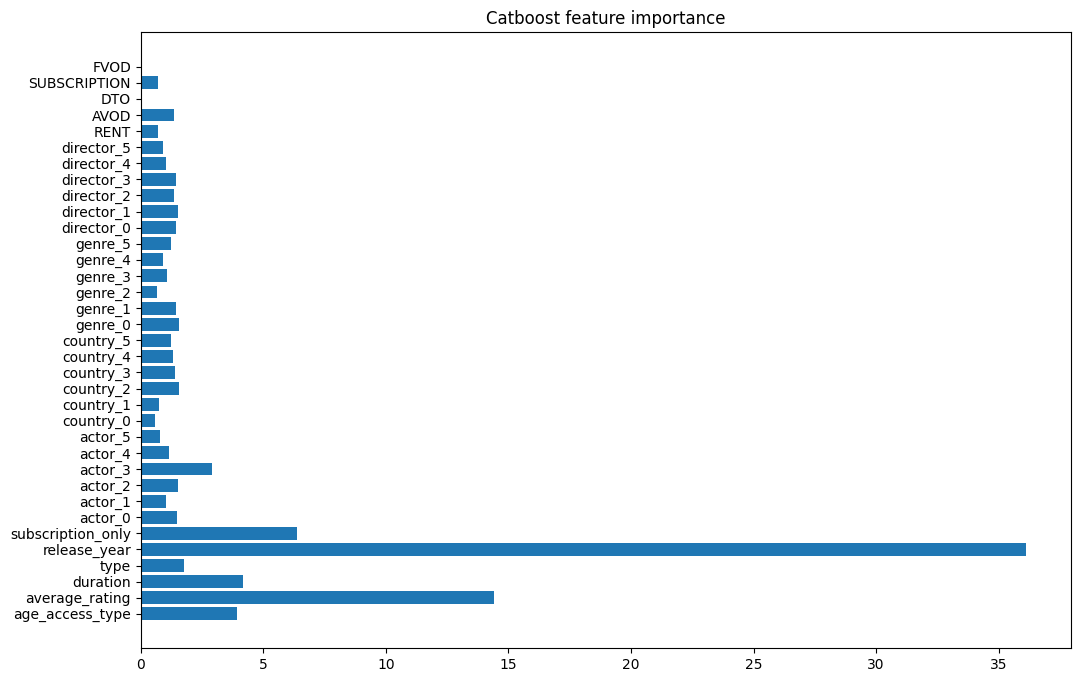

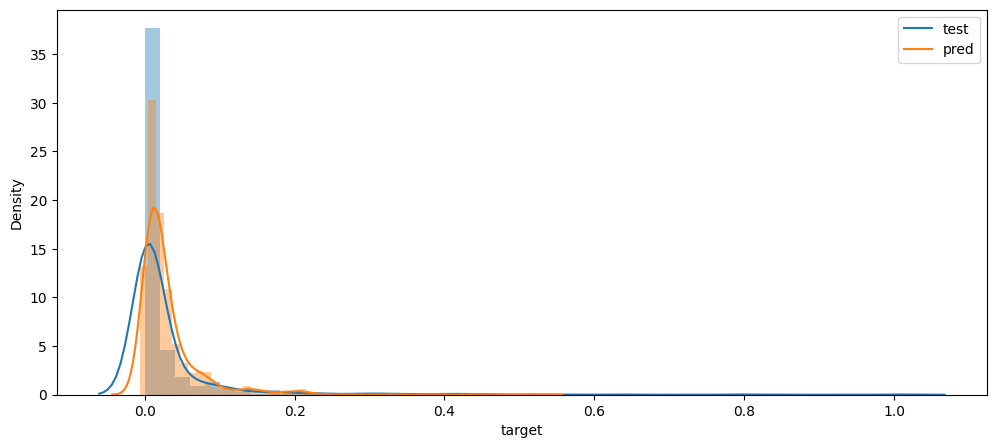

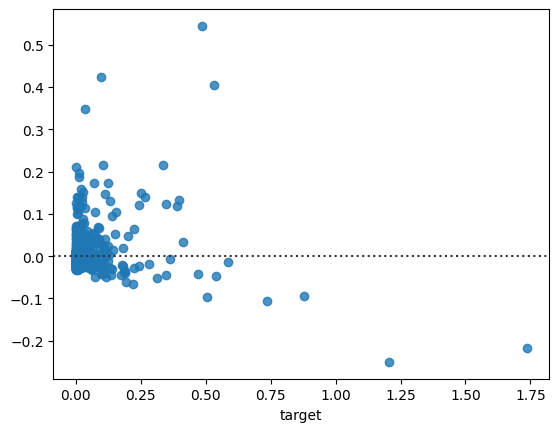

In [83]:
get_metrics(y_test, y_pred, X)
get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png')
draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution')
draw_residuals(y_test, y_pred, save_fig=False)

In [48]:
len(y_pred[y_pred <= 0])

71

In [87]:
calc_metrics(y_test, y_pred)

*** VAL **: 
MSE:   0.0045609797537924405
RMSE:  0.06753502612565157
R2:    0.2360049275931868
MAE:   0.029449491515247908
MedAE: 0.012390380156556524
------------------------------
